The general goal of this notebook is to develop pre-processing scripts that aim to predict percentiles of the outputs's unconditional PDF rather than physical values.

# Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Load training set in memory

## Load data

In [4]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [5]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [6]:
path_TRAIN = path_data + '2021_01_24_O3_TRAIN_shuffle.nc'

In [7]:
path_TRAIN

'/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/2021_01_24_O3_TRAIN_shuffle.nc'

In [7]:
train_data = xr.open_dataset(path_TRAIN)

In [8]:
train_data

<xarray.Dataset>
Dimensions:    (sample: 47177728, var_names: 214)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'
Dimensions without coordinates: sample
Data variables:
    time       (sample) int64 ...
    lat        (sample) float64 ...
    lon        (sample) float64 ...
    vars       (sample, var_names) float64 ...

In [9]:
train_data['var_names']

<xarray.DataArray 'var_names' (var_names: 214)>
array(['QBP', 'QBP', 'QBP', ..., 'QRS', 'QRS', 'QRS'], dtype=object)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'

In [11]:
train_data['vars'].shape

(47177728, 214)

In [18]:
train_data['var_names'][-120:]

<xarray.DataArray 'var_names' (var_names: 120)>
array(['PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL',
       'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL',
       'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL', 'QRL',
       'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS', 'QRS',
       'QRS', 'QRS

## Create histogram bins based on max,min

In [20]:
train_data_max = train_data['vars'].max(axis=0)

In [21]:
train_data_min = train_data['vars'].min(axis=0)

In [49]:
train_data_max[-121]

<xarray.DataArray 'vars' ()>
array(992.12207)
Coordinates:
    var_names  <U5 'LHFLX'

In [50]:
train_data_min[-121]

<xarray.DataArray 'vars' ()>
array(-106.082199)
Coordinates:
    var_names  <U5 'LHFLX'

In [51]:
train_data_max.shape

(214,)

In [52]:
214-121

93

In [53]:
train_data_max[94]

<xarray.DataArray 'vars' ()>
array(0.)
Coordinates:
    var_names  <U3 'PHQ'

In [54]:
train_data_max[93]

<xarray.DataArray 'vars' ()>
array(992.12207)
Coordinates:
    var_names  <U5 'LHFLX'

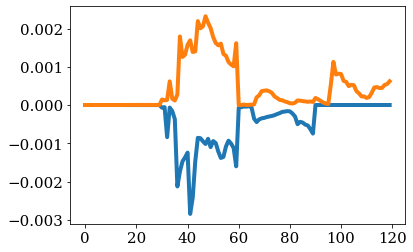

In [24]:
plt.plot(train_data_min[-120:])
plt.plot(train_data_max[-120:])

In [25]:
train_data_bins = np.linspace(start=train_data_min,stop=train_data_max,num=1000)

In [26]:
train_data_bins.shape

(1000, 214)

In [40]:
train_data_min[-91]

<xarray.DataArray 'vars' ()>
array(-2.703581e-06)
Coordinates:
    var_names  <U3 'PHQ'

In [42]:
train_data_max[-91]

<xarray.DataArray 'vars' ()>
array(1.331972e-06)
Coordinates:
    var_names  <U3 'PHQ'

array([-2.70358146e-06, -2.69954187e-06, -2.69550227e-06, -2.69146268e-06,
       -2.68742309e-06, -2.68338349e-06, -2.67934390e-06, -2.67530431e-06,
       -2.67126471e-06, -2.66722512e-06, -2.66318553e-06, -2.65914593e-06,
       -2.65510634e-06, -2.65106675e-06, -2.64702715e-06, -2.64298756e-06,
       -2.63894797e-06, -2.63490837e-06, -2.63086878e-06, -2.62682919e-06,
       -2.62278959e-06, -2.61875000e-06, -2.61471041e-06, -2.61067081e-06,
       -2.60663122e-06, -2.60259163e-06, -2.59855203e-06, -2.59451244e-06,
       -2.59047285e-06, -2.58643326e-06, -2.58239366e-06, -2.57835407e-06,
       -2.57431448e-06, -2.57027488e-06, -2.56623529e-06, -2.56219570e-06,
       -2.55815610e-06, -2.55411651e-06, -2.55007692e-06, -2.54603732e-06,
       -2.54199773e-06, -2.53795814e-06, -2.53391854e-06, -2.52987895e-06,
       -2.52583936e-06, -2.52179976e-06, -2.51776017e-06, -2.51372058e-06,
       -2.50968098e-06, -2.50564139e-06, -2.50160180e-06, -2.49756220e-06,
       -2.49352261e-06, -

## Calculate quantile for each output variable

In [72]:
train_data['vars'][:,-91].quantile(np.array([0,1])).values

array([-2.70358146e-06,  1.33197216e-06])

In [7]:
quantile_array = np.linspace(0,1,1001)

In [8]:
PERC_array = np.zeros((1001,184))

In [74]:
for ivar in range(214):
    print('ivar=',ivar,'           ',end='\r')
    PERC_array[:,ivar] = train_data['vars'][:,ivar].quantile(quantile_array).values

In [75]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

hf = open(pathPKL+'2021_01_24_O3_TRAIN_shuffle'+'_PERC.pkl','wb')

F_data = {'quantile_array':quantile_array,'PERC_array':PERC_array}

pickle.dump(F_data,hf)
hf.close()

In [76]:
F_data

{'quantile_array': array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
 'PERC_array': array([[9.94927973e-07, 9.68830705e-07, 4.62277796e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.99745453e-07, 9.85569386e-07, 5.24233599e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00150617e-06, 9.87641442e-07, 5.24234395e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.77804845e-06, 1.73643605e-06, 1.46164996e-06, ...,
         4.32690976e-05, 4.00223369e-05, 3.74600383e-05],
        [1.78130600e-06, 1.74002975e-06, 1.46422724e-06, ...,
         6.53455651e-05, 7.07500345e-05, 9.00195526e-05],
        [1.79556821e-06, 1.75865364e-06, 1.48329934e-06, ...,
         5.22865215e-04, 5.47407486e-04, 6.19579223e-04]])}

In [79]:
F_data['PERC_array'][:,-91]

array([-2.70358146e-06, -5.69551777e-07, -4.80656313e-07, ...,
        4.20529032e-07,  4.78835986e-07,  1.33197216e-06])

## Repeat for every dataset

In [8]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [9]:
quantile_array = np.linspace(0,1,1001)

In [10]:
path_array = [
    '2021_06_03_RG_TRAIN_shuffle.nc',
    '2021_06_03_RG_VALID.nc',
    '2021_06_06_RG_TEST.nc'
#    '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
#     '2021_04_18_RG_VALID_M4K.nc',
#     '2021_04_18_RG_TEST_M4K.nc',
#     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
#     '2021_04_18_RG_VALID_P4K.nc',
#     '2021_04_18_RG_TEST_P4K.nc'
]

In [12]:
#path_array = [
#     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
#     '2021_03_18_O3_VALID_M4K.nc',
#     '2021_03_18_O3_TEST_P4K.nc',
#     '2021_01_24_O3_TRAIN_shuffle.nc',
#     '2021_03_18_O3_TEST_M4K.nc',
#     '2021_01_24_O3_VALID.nc',
#     '2021_01_24_O3_TEST.nc',
#     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
#    '2021_03_18_O3_VALID_P4K.nc'
#]

In [11]:
Ninput = 184

In [12]:
Ninput

184

In [13]:
path_array

['2021_06_03_RG_TRAIN_shuffle.nc',
 '2021_06_03_RG_VALID.nc',
 '2021_06_06_RG_TEST.nc']

In [ ]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data = xr.open_dataset(path_var)
    
    PERC_array = np.zeros((1001,Ninput))
    
    for ivar in range(Ninput):
        print('ivar=',ivar,'           ',end='\r')
        PERC_array[:,ivar] = train_data['vars'][:,ivar].quantile(quantile_array).values
    
    hf = open(pathPKL+'/'+path+'_PERC.pkl','wb')

    F_data = {'quantile_array':quantile_array,'PERC_array':PERC_array}

    pickle.dump(F_data,hf)
    hf.close()
    print('\n')

ipath= 0 path= 2021_06_03_RG_TRAIN_shuffle.nc      


# Test interpolation onto percentile array

Directly test in preprocessing mode to facilitate duplication of training/validation/test in percentile space

## Testing different interpolation functions

### Imports

In [11]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [12]:
pathPKL_train = pathPKL + '/PKL_DATA2021_03_18_O3_TRAIN_M4K_shuffle.nc_PERC.pkl'
pathPKL_test = pathPKL + '/PKL_DATA2021_03_18_O3_TEST_P4K.nc_PERC.pkl'

In [13]:
hf = open(pathPKL_train,'rb')
tmp = pickle.load(hf)
PERC_array = tmp['PERC_array']
quantile_array = tmp['quantile_array']

FileNotFoundError: [Errno 2] No such file or directory: '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/PKL_DATA2021_03_18_O3_TRAIN_M4K_shuffle.nc_PERC.pkl'

In [ ]:
PERC_array.shape

### Load small data

In [20]:
path_dm4K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
ds = xr.open_mfdataset(path_dm4K+'0001-01-05-00000.nc',\
                          decode_times=False)

In [21]:
var0 = ds['PHQ'][1:]

In [57]:
import numpy as np
from scipy.interpolate import interp1d
import scipy

class scipy.interpolate.interp1d(x, y, kind='linear', axis=- 1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)[source]

In [40]:
var_interp = interp1d(x=PERC_array[:,-91],y=quantile_array)

In [41]:
scale_dict = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [42]:
scale_dict['PHQ']

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)

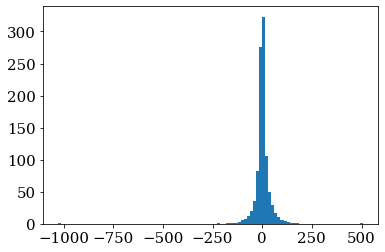

In [43]:
plt.hist(scale_dict['PHQ'][-1]*PERC_array[:,-91],bins=100);

In [44]:
var0.shape

(47, 30, 64, 128)

In [45]:
var0_afterinterp = var_interp(var0[:,-1,:,:])

In [47]:
var0_afterinterp.shape

(47, 64, 128)

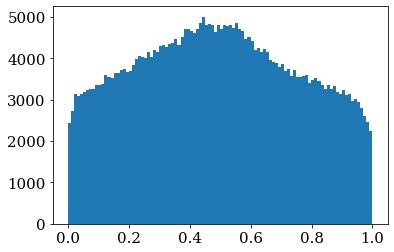

In [50]:
plt.hist(var0_afterinterp.flatten(),bins=100);

In [51]:
path_dm4K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
ds = xr.open_mfdataset(path_dm4K+'0001-03-22-00000.nc',\
                          decode_times=False)

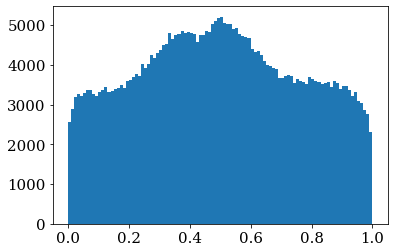

In [52]:
plt.hist((var_interp(ds['PHQ'][:,-1,:,:])).flatten(),bins=100);

In [60]:
var_interp = interp1d(x=PERC_array[:,-1],y=quantile_array,fill_value=(0,1))

In [64]:
var_interp._extrapolate='True'

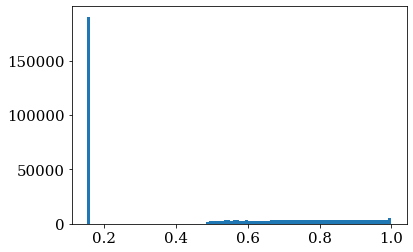

In [65]:
plt.hist((var_interp(ds['QRS'][:,-1,:,:])).flatten(),bins=100);

In [66]:
var_interp = interp1d(x=PERC_array[:,-31],y=quantile_array,fill_value=(0,1))

plt.hist((var_interp(ds['QRL'][:,-1,:,:])).flatten(),bins=100);

## Check with original dataset

In [8]:
path_array = [
#    '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
#    '2021_03_18_O3_VALID_M4K.nc',
    '2021_03_18_O3_TEST_P4K.nc',
#    '2021_01_24_O3_TRAIN_shuffle.nc',
#    '2021_03_18_O3_TEST_M4K.nc',
#    '2021_01_24_O3_VALID.nc',
#    '2021_01_24_O3_TEST.nc',
#    '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
#    '2021_03_18_O3_VALID_P4K.nc'
]

In [10]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data = xr.open_dataset(path_var)
    
    hf = open(pathPKL+'/'+path+'_PERC.pkl','rb')
    tmp = pickle.load(hf)
    
    PERC_array = tmp['PERC_array']
    quantile_array = tmp['quantile_array']

ipath= 0 path= 2021_03_18_O3_TEST_P4K.nc      


In [12]:
import numpy as np
from scipy.interpolate import interp1d
import scipy

In [13]:
interp_fx = interp1d(x=PERC_array[:,-91],y=quantile_array)

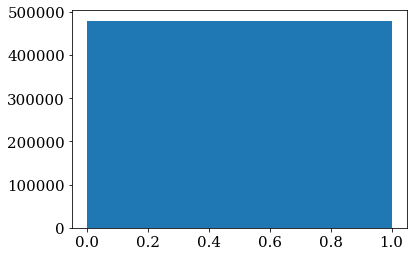

In [14]:
plt.hist((interp_fx(train_data['vars'][:,-91])).flatten(),bins=100);

## Develop preprocessing routine for convert_dataset_20191113

TODO = Test
def compute_perc(ds, var, PERC_array, quantile_array):
    
    from scipy.interpolate import interp1d
    
    # Load variable from dataset
    var0 = ds[var[:-4]][1:]
    # Manually entering ranges for each variable: 
    # This should change and PERC_array should be a dictionary with varianble names
    i0 = {}
    i0['PHQ'] = 94
    i0['TPHYSTND'] = 124
    i0['QRL'] = 154
    i0['QRS'] = 184
    
    # Project onto 1D percentile space to form the output
    output_percentile = 0*var0**0 # Initialization
    for ilev in range(var0.shape[1]):
        print('Interpolating level ',ilev,'out of ',var0.shape[1])
        interp_fx = interp1d(x=PERC_array[:,i0[var[:-4]]+ilev,:,:],y=quantile_array)
        output_percentile[:,ilev,:,:] = interp_fx(var0[:,ilev,:,:])
        
    return output_percentile

Load dataset

In [32]:
path_PERC = pathPKL+'/'+'2021_03_18_O3_TRAIN_M4K_shuffle.nc'+'_PERC.pkl'

In [33]:
path_PERC

'/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/2021_03_18_O3_TRAIN_M4K_shuffle.nc_PERC.pkl'

In [34]:
import pickle
hf = open(path_PERC,'rb')
tmp = pickle.load(hf)
PERC_array = tmp['PERC_array']
quantile_array = tmp['quantile_array']

In [17]:
path_m4K_file = '/DFS-L/DATA/pritchard/tbeucler/SPCAM//sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.00'

In [18]:
datam4K = xr.open_mfdataset(path_m4K_file+'01-06-1*-00000.nc')

In [125]:
var = 'QRLPERC'
ds = datam4K

In [126]:
var0 = ds[var[:-4]][1:]

In [127]:
var0

<xarray.DataArray 'QRL' (time: 479, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(479, 30, 64, 128), dtype=float32, chunksize=(47, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-06-10 00:30:00 ... 0001-06-19 23:29:59
Attributes:
    units:      K/s
    long_name:  Longwave heating rate

In [24]:
i0 = {}
i0['PHQ'] = 94
i0['TPHYSTND'] = 124
i0['QRL'] = 154
i0['QRS'] = 184

In [25]:
output_percentile = 0*var0**0 # Initialization

In [36]:
S = var0.shape[1]

In [37]:
S

30

In [79]:
ilev = 29

In [80]:
interp_fx = interp1d(x=PERC_array[:,i0[var[:-4]]+ilev],y=quantile_array)

In [81]:
interp_fx

In [82]:
var0

<xarray.DataArray 'PHQ' (time: 479, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(479, 30, 64, 128), dtype=float32, chunksize=(47, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-06-10 00:30:00 ... 0001-06-19 23:29:59
Attributes:
    units:      kg/kg/s
    long_name:  Specific humidity physics tendency

In [83]:
var0.shape

(479, 30, 64, 128)

In [84]:
var0[:,ilev,:,:].shape

(479, 64, 128)

In [85]:
var0_interp = interp_fx(var0[:,ilev,:,:])

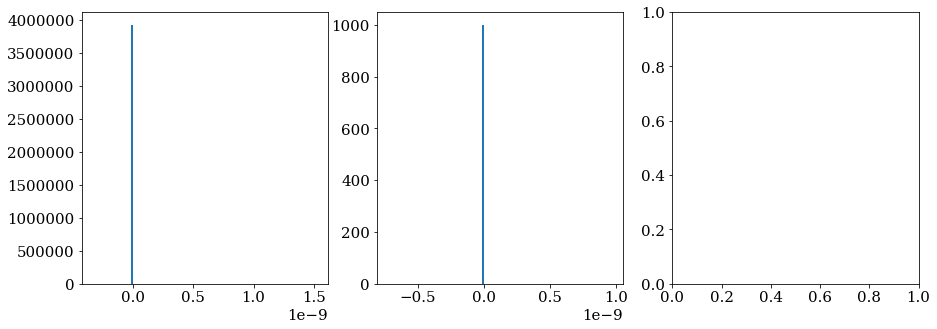

In [92]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(var0[:,ilev,:,:].values.flatten(),bins=100);
ax[1].hist(PERC_array[:,i0[var[:-4]]+ilev],bins=100);
#ax[2].hist(var0_interp.flatten(),bins=100);

In [74]:
PERC_array[:,i0[var[:-4]]+ilev]

array([-2.81775812e-07, -7.93939854e-08, -6.59038065e-08, ...,
        1.14236935e-08,  1.62509410e-08,  2.25147929e-07])

In [88]:
var0.shape

(479, 30, 64, 128)

In [128]:
# Project onto 1D percentile space to form the output
output_percentile = np.zeros(var0.shape) # Initialization
for ilev in range(var0.shape[1]):
    print('Interpolating level ',ilev,'out of ',var0.shape[1])
    interp_fx = interp1d(x=PERC_array[:,i0[var[:-4]]+ilev],y=quantile_array,bounds_error=False)
    output_percentile[:,ilev,:,:] = interp_fx(var0[:,ilev,:,:].values)

Interpolating level  0 out of  30
Interpolating level  1 out of  30
Interpolating level  2 out of  30
Interpolating level  3 out of  30
Interpolating level  4 out of  30
Interpolating level  5 out of  30
Interpolating level  6 out of  30
Interpolating level  7 out of  30
Interpolating level  8 out of  30
Interpolating level  9 out of  30
Interpolating level  10 out of  30
Interpolating level  11 out of  30
Interpolating level  12 out of  30
Interpolating level  13 out of  30
Interpolating level  14 out of  30
Interpolating level  15 out of  30
Interpolating level  16 out of  30
Interpolating level  17 out of  30
Interpolating level  18 out of  30
Interpolating level  19 out of  30
Interpolating level  20 out of  30
Interpolating level  21 out of  30
Interpolating level  22 out of  30
Interpolating level  23 out of  30
Interpolating level  24 out of  30
Interpolating level  25 out of  30
Interpolating level  26 out of  30
Interpolating level  27 out of  30
Interpolating level  28 out of

In [129]:
output_percentile = output_percentile+0*var0**0

In [130]:
output_percentile

<xarray.DataArray 'QRL' (time: 479, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(479, 30, 64, 128), dtype=float64, chunksize=(47, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-06-10 00:30:00 ... 0001-06-19 23:29:59

In [131]:
var0[:,ilev,:,:].values.max()

4.4420296e-05

In [132]:
PERC_array[:,i0[var[:-4]]+ilev].max()

5.5037166021065786e-05

In [133]:
ilev = 29

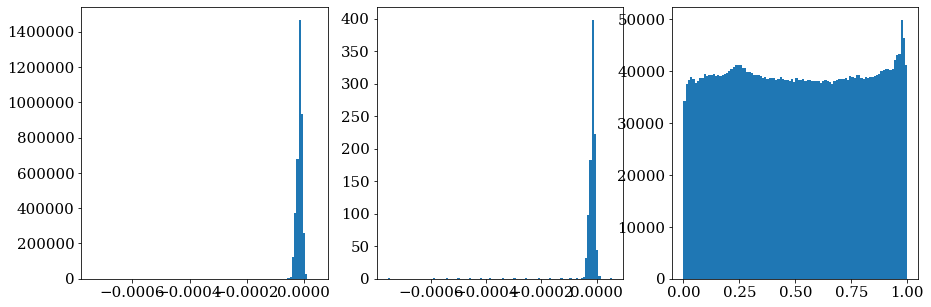

In [134]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(var0[:,ilev,:,:].values.flatten(),bins=100);
ax[1].hist(PERC_array[:,i0[var[:-4]]+ilev],bins=100);
ax[2].hist(output_percentile[:,ilev,:,:].values.flatten(),bins=100);

# Make Distributions Figure for final postdoc talks

## Font size

In [14]:
fz = 40
lw = 6
siz = 100

In [15]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

## Load data and coordinates

In [16]:
# Load coordinates (just pick any file from the climate model run)

# Comet path below
# coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
#                     decode_times=False)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [17]:
# Comet path below
# TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
# path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'

# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

In [18]:
coor.lev

<xarray.DataArray 'lev' (lev: 30)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  38.2683  ,  54.59548 ,
        72.012451,  87.82123 , 103.317127, 121.547241, 142.994039, 168.22508 ,
       197.908087, 232.828619, 273.910817, 322.241902, 379.100904, 445.992574,
       524.687175, 609.778695, 691.38943 , 763.404481, 820.858369, 859.534767,
       887.020249, 912.644547, 936.198398, 957.48548 , 976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [19]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
#    '2021_03_18_O3_VALID_M4K.nc',
#    '2021_03_18_O3_TEST_P4K.nc',
#    '2021_01_24_O3_TRAIN_shuffle.nc',
#    '2021_03_18_O3_TEST_M4K.nc',
#    '2021_01_24_O3_VALID.nc',
#    '2021_01_24_O3_TEST.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
#    '2021_03_18_O3_VALID_P4K.nc'
]

In [20]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [21]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [22]:
train_data = {}

In [23]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data[path] = xr.open_dataset(path_var)

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc      
ipath= 1 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc      


In [24]:
train_data

{'2021_03_18_O3_TRAIN_M4K_shuffle.nc': <xarray.Dataset>
 Dimensions:    (sample: 47177728, var_names: 214)
 Coordinates:
   * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'
 Dimensions without coordinates: sample
 Data variables:
     time       (sample) int64 ...
     lat        (sample) float64 ...
     lon        (sample) float64 ...
     vars       (sample, var_names) float64 ...,
 '2021_03_18_O3_TRAIN_P4K_shuffle.nc': <xarray.Dataset>
 Dimensions:    (sample: 47177728, var_names: 214)
 Coordinates:
   * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'
 Dimensions without coordinates: sample
 Data variables:
     time       (sample) int64 ...
     lat        (sample) float64 ...
     lon        (sample) float64 ...
     vars       (sample, var_names) float64 ...}

## Distribution of q vs RH at different levels

In [25]:
def compute_bp(ds, var):
    """GCM state at beginning of time step before physics.
    ?BP = ?AP - physical tendency * dt

    Args:
        ds: entire xarray dataset
        var: BP variable name

    Returns:
        bp: xarray dataarray containing just BP variable, with the first time step cut.
    """
    base_var = var[:-2] + 'AP'
    return (ds[base_var] - ds[phy_dict[base_var]] * DT)[1:]  # Not the first time step

In [32]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

In [56]:
def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)
    return Rv*p*qv/(R*esat(T))
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))


In [47]:
train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,90]

<xarray.DataArray 'vars' (sample: 47177728)>
[47177728 values with dtype=float64]
Coordinates:
    var_names  <U2 'PS'
Dimensions without coordinates: sample

In [28]:
coor.lev[19]

<xarray.DataArray 'lev' ()>
array(609.778695)
Coordinates:
    lev      float64 609.8
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [63]:
a = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,19]

In [64]:
a = a.values

In [65]:
histQm4K,edgm4K = np.histogram(a, bins=100, density=True)

In [39]:
a = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,19]

In [40]:
a = a.values

In [41]:
histQp4K,edgp4K = np.histogram(a, bins=100, density=True)

In [51]:
aT = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,49]
aq = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,19]
aPS = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,90]

In [52]:
print('T')
aT = aT.values
print('q')
aq = aq.values
print('PS')
aPS = aPS.values

T
q
PS


In [55]:
a = RH(aT,aq,P0,aPS,hyam[19],hybm[19])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [58]:
a.shape

(47177728,)

In [62]:
histRHm4K,edgm4K_RH = np.histogram(a, bins=100, density=True)

In [66]:
aT = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,49]
aq = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,19]
aPS = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,90]

In [67]:
print('T')
aT = aT.values
print('q')
aq = aq.values
print('PS')
aPS = aPS.values

T
q
PS


In [68]:
a = RH(aT,aq,P0,aPS,hyam[19],hybm[19])

In [69]:
histRHP4K,edgP4K_RH = np.histogram(a, bins=100, density=True)

Text(0.5, 0, 'Relative humidity')

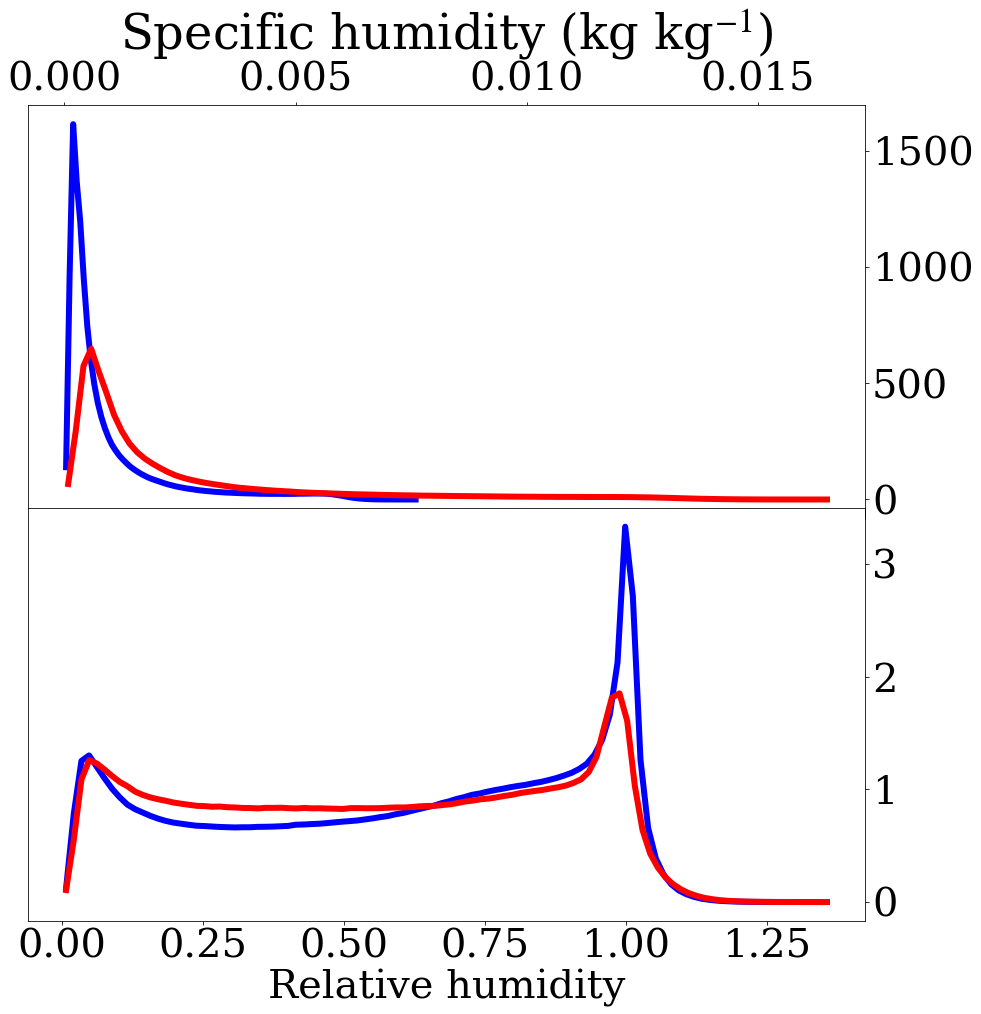

In [160]:
fig,ax = plt.subplots(2,1,figsize=(15,15))

plt.subplots_adjust(wspace=None, hspace=-0.025)

# Top subplot = Specific humidity
ax[0].plot(edg2bin(edgm4K),histQm4K,color='b')
ax[0].plot(edg2bin(edgp4K),histQp4K,color='r')
ax[0].yaxis.tick_right()
#ax[0].set_xlabel('Specific humidity (kg kg$^{-1}$)')
ax[0].xaxis.tick_top()
ax[0].set_title('Specific humidity (kg kg$^{-1}$)')

# Bottom subplot = Relative humidity
ax[1].plot(edg2bin(edgm4K_RH),histRHm4K,color='b')
ax[1].plot(edg2bin(edgP4K_RH),histRHP4K,color='r')
ax[1].yaxis.tick_right()
ax[1].set_xlabel('Relative humidity')
#ax[1].set_title('PDF')

## Distribution of T vs BCONS at different levels

In [91]:

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

def theta_e_calc(T,qv,P0,PS,hyam,hybm):
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    tmelt  = 273.15
    CPD = 1005.7
    CPV = 1870.0
    CPVMCL = 2320.0
    RV = 461.5
    RD = 287.04
    EPS = RD/RV
    ALV0 = 2.501E6

    r = qv / (1. - qv)
    # get ev in hPa 
    ev_hPa = 100*p*r/(EPS+r)
    #get TL
    TL = (2840. / ((3.5*np.log(T)) - (np.log(ev_hPa)) - 4.805)) + 55.
    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28*r))
    P0_norm = (P0/(hyam*P0+hybm*PS))

    theta_e = T * P0_norm**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))

    return theta_e

def theta_e_sat_calc(T,qv,P0,PS,hyam,hybm):
    return theta_e_calc(T,qsat(T,P0,PS,hyam,hybm),P0,PS,hyam,hybm)

# TBP = compute_bp(ds,'TBP')
# QBP = compute_bp(ds,'QBP')

# return G*(theta_e_calc(TBP,QBP,ds['P0'],ds['PS'][1:,:,:],ds['hyam'],ds['hybm'])[:,-1,:,:]-\
#           theta_e_sat_calc(TBP,QBP,ds['P0'],ds['PS'][1:,:,:],ds['hyam'],ds['hybm']))/\
# theta_e_sat_calc(TBP,QBP,ds['P0'],ds['PS'][1:,:,:],ds['hyam'],ds['hybm'])   

In [130]:
ilev = 23

In [131]:
coor.lev[ilev]

<xarray.DataArray 'lev' ()>
array(859.534767)
Coordinates:
    lev      float64 859.5
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [132]:
a = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,30+ilev]

In [133]:
a = a.values

In [134]:
histTm4K,edgm4K_T = np.histogram(a, bins=100, density=True)

In [135]:
a = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,30+ilev]

In [136]:
a = a.values

In [137]:
histTp4K,edgp4K_T = np.histogram(a, bins=100, density=True)

In [138]:
aT = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,30+ilev]
aq = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,ilev]
aPS = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,90]

In [139]:
print('T')
aT = aT.values
print('q')
aq = aq.values
print('PS')
aPS = aPS.values

T
q
PS


In [140]:
aTNS = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,59]
aqNS = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,29]

In [141]:
print('T')
aTNS = aTNS.values
print('q')
aqNS = aqNS.values

T
q


In [142]:
a = G*(theta_e_calc(aTNS,aqNS,P0,aPS,hyam[29],hybm[29])-\
   theta_e_sat_calc(aT,aq,P0,aPS,hyam[ilev],hybm[ilev]))/\
theta_e_sat_calc(aT,aq,P0,aPS,hyam[ilev],hybm[ilev])  

In [143]:
histBm4K,edgm4K_B = np.histogram(a, bins=100, density=True)

In [144]:
aT = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,30+ilev]
aq = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,ilev]
aPS = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,90]

In [145]:

print('T')
aT = aT.values
print('q')
aq = aq.values
print('PS')
aPS = aPS.values

T
q
PS


In [146]:
aTNS = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,59]
aqNS = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,29]

In [147]:
print('T')
aTNS = aTNS.values
print('q')
aqNS = aqNS.values

T
q


In [148]:
a = G*(theta_e_calc(aTNS,aqNS,P0,aPS,hyam[29],hybm[29])-\
   theta_e_sat_calc(aT,aq,P0,aPS,hyam[ilev],hybm[ilev]))/\
theta_e_sat_calc(aT,aq,P0,aPS,hyam[ilev],hybm[ilev])  

In [149]:
histBp4K,edgp4K_B = np.histogram(a, bins=100, density=True)

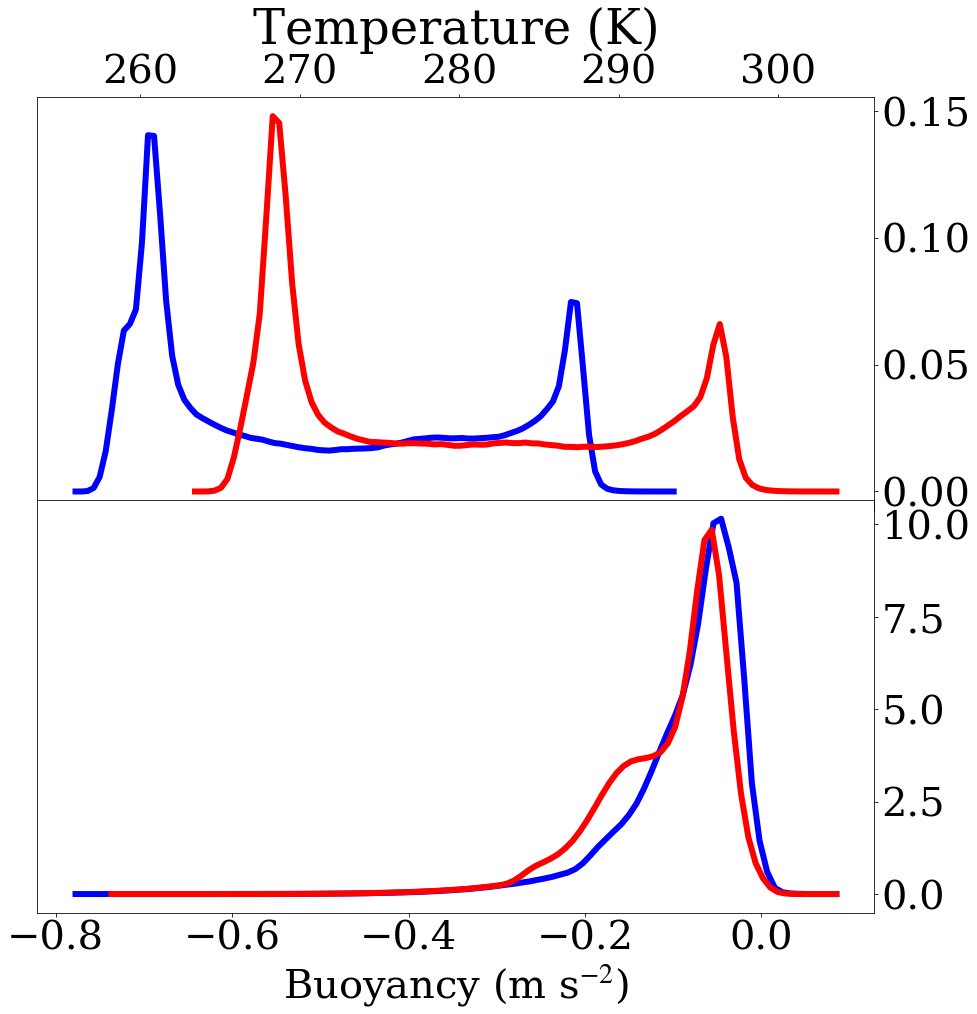

In [161]:
fig,ax = plt.subplots(2,1,figsize=(15,15))

plt.subplots_adjust(wspace=None, hspace=-0.025)

# Top subplot = Specific humidity
ax[0].plot(edg2bin(edgm4K_T),histTm4K,color='b')
ax[0].plot(edg2bin(edgp4K_T),histTp4K,color='r')
ax[0].set_title('Temperature (K)')
ax[0].yaxis.tick_right()
ax[0].xaxis.tick_top()

# Bottom subplot = Relative humidity
ax[1].plot(edg2bin(edgm4K_B),histBm4K,color='b')
ax[1].plot(edg2bin(edgp4K_B),histBp4K,color='r')
ax[1].set_xlabel('Buoyancy (m s$^{-2}$)')
ax[1].yaxis.tick_right()

## Distribution of LHF vs LHF/nsDELQ 

In [86]:
train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,93]

<xarray.DataArray 'vars' (sample: 47177728)>
[47177728 values with dtype=float64]
Coordinates:
    var_names  <U5 'LHFLX'
Dimensions without coordinates: sample

In [25]:
aLHF = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,93]

In [26]:
aLHF = aLHF.values

In [27]:
histLHFm4K,edgm4K_LHF = np.histogram(aLHF, bins=100, density=True)

In [28]:
aLHF = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,93]

In [29]:
aLHF = aLHF.values

In [30]:
histLHFp4K,edgp4K_LHF = np.histogram(aLHF, bins=100, density=True)

In [112]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

# QBP = compute_bp(ds,'QBP')
# Qden = qsat(ds['TS'][1:,:,:],ds['P0'],ds['PS'][1:,:,:],ds['hyam'][:,-1],ds['hybm'][:,-1])-QBP[:,-1,:,:].values
# return ds['LHFLX'][:-1]/(L_V*np.maximum(eps,Qden))

In [109]:
aTNS = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,59]
aqNS = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,29]
aPS = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,90]
aLHF = train_data['2021_03_18_O3_TRAIN_M4K_shuffle.nc']['vars'][:,93]

In [110]:
print('T')
aTNS = aTNS.values
print('q')
aqNS = aqNS.values
print('PS')
aPS = aPS.values
print('LHF')
aLHF = aLHF.values

T
q
PS
LHF


In [113]:
a = aLHF/(L_V*np.maximum(1e-3,(qsat(aTNS,P0,aPS,hyam[-1],hybm[-1])-aqNS)))

In [114]:
histLHFnm4K,edgm4K_LHFn = np.histogram(a, bins=100, density=True)

In [115]:
aTNS = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,59]
aqNS = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,29]
aPS = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,90]
aLHF = train_data['2021_03_18_O3_TRAIN_P4K_shuffle.nc']['vars'][:,93]

In [116]:
print('T')
aTNS = aTNS.values
print('q')
aqNS = aqNS.values
print('PS')
aPS = aPS.values
print('LHF')
aLHF = aLHF.values

T
q
PS
LHF


In [117]:
a = aLHF/(L_V*np.maximum(1e-3,(qsat(aTNS,P0,aPS,hyam[-1],hybm[-1])-aqNS)))

In [118]:
histLHFnp4K,edgp4K_LHFn = np.histogram(a, bins=100, density=True)

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'PDF')

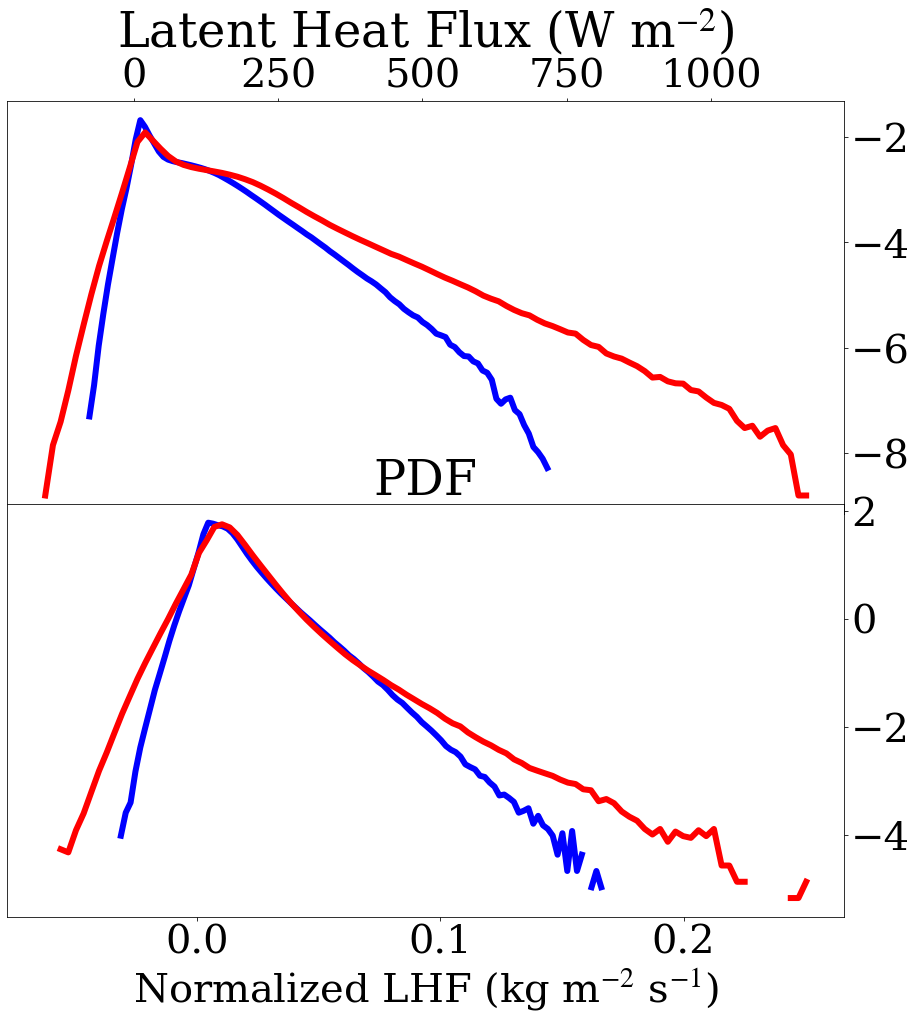

In [39]:
fig,ax = plt.subplots(2,1,figsize=(15,15))

plt.subplots_adjust(wspace=None, hspace=-0.025)

# Top subplot = Specific humidity
ax[0].plot(edg2bin(edgm4K_LHF),np.log10(histLHFm4K),color='b')
ax[0].plot(edg2bin(edgp4K_LHF),np.log10(histLHFp4K),color='r')
ax[0].set_title('Latent Heat Flux (W m$^{-2}$)')
ax[0].yaxis.tick_right()
ax[0].xaxis.tick_top()
#ax[0].set_title('PDF')

#Bottom subplot = Relative humidity
ax[1].plot(edg2bin(test['edgm4K_LHFn']),np.log10(test['histLHFnm4K']),color='b')
ax[1].plot(edg2bin(test['edgp4K_LHFn']),np.log10(test['histLHFnp4K']),color='r')
ax[1].set_xlabel('Normalized LHF (kg m$^{-2}$ s$^{-1}$)')
ax[1].yaxis.tick_right()
ax[1].set_title('PDF')

## Save all histograms

In [151]:
F_data = {'edgm4K':edgm4K,'histQm4K':histQm4K,'edgp4K':edgp4K,'histQp4K':histQp4K,'edgm4K_RH':edgm4K_RH,
          'histRHm4K':histRHm4K,'edgP4K_RH':edgP4K_RH,'histRHP4K':histRHP4K,'edgm4K_T':edgm4K_T,
          'histTm4K':histTm4K,'edgp4K_T':edgp4K_T,'histTp4K':histTp4K,'edgm4K_B':edgm4K_B,
          'histBm4K':histBm4K,'edgp4K_B':edgp4K_B,'histBp4K':histBp4K,'edgm4K_LHF':edgm4K_LHF,
          'histTm4K':histTm4K,'edgp4K_LHF':edgp4K_LHF,'histTp4K':histTp4K,'edgm4K_LHFn':edgm4K_LHFn,
          'histLHFnm4K':histLHFnm4K,'edgp4K_LHFn':edgp4K_LHFn,'histLHFnp4K':histLHFnp4K}

In [152]:
path = '2021_05_05_distributions_RH_BCONS_LHFn'

hf = open(pathPKL+'/'+path+'.pkl','wb')

F_data = {'quantile_array':quantile_array,'PERC_array':PERC_array}

pickle.dump(F_data,hf)
hf.close()
print('\n')

NameError: name 'quantile_array' is not defined

In [163]:
F_data = {'edgm4K':edgm4K,'histQm4K':histQm4K,'edgp4K':edgp4K,'histQp4K':histQp4K,'edgm4K_RH':edgm4K_RH,
          'histRHm4K':histRHm4K,'edgP4K_RH':edgP4K_RH,'histRHP4K':histRHP4K,'edgm4K_T':edgm4K_T,
          'histTm4K':histTm4K,'edgp4K_T':edgp4K_T,'histTp4K':histTp4K,'edgm4K_B':edgm4K_B,
          'histBm4K':histBm4K,'edgp4K_B':edgp4K_B,'histBp4K':histBp4K,'edgm4K_LHF':edgm4K_LHF,
          'histTm4K':histTm4K,'edgp4K_LHF':edgp4K_LHF,'histTp4K':histTp4K,'edgm4K_LHFn':edgm4K_LHFn,
          'histLHFnm4K':histLHFnm4K,'edgp4K_LHFn':edgp4K_LHFn,'histLHFnp4K':histLHFnp4K}

In [36]:
path = '2021_05_05_distributions_RH_BCONS_LHFn'

hf = open(pathPKL+'/'+path+'.pkl','rb')

test = pickle.load(hf)
hf.close()
print('\n')

# Make loss vs time figure for final postdoc talks

## Preliminary data analysis

In [7]:
path_PKL = '/export/nfs0home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [8]:
path_MLR_BF = path_PKL + 'PKL_DATA2021_04_26_MLR_hist.pkl'
hf = open(path_MLR_BF,'rb')
hist_MLR_BF = pickle.load(hf)
hist_MLR_BF = hist_MLR_BF['hist']

In [9]:
path_NN_BF1 = path_PKL + 'PKL_DATA2021_04_26_NN_hist.pkl'
path_NN_BF2 = path_PKL + 'PKL_DATA2021_05_04_NN_hist.pkl'

hf = open(path_NN_BF1,'rb')
hist_NN_BF1 = pickle.load(hf)
hist_NN_BF1 = hist_NN_BF1['hist']

hf = open(path_NN_BF2,'rb')
hist_NN_BF2 = pickle.load(hf)
hist_NN_BF2 = hist_NN_BF2['hist']

In [10]:
path_MLR_CI = path_PKL + 'PKL_DATA2021_04_26_MLR_RH_BCONS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_CI,'rb')
hist_MLR_CI = pickle.load(hf)
hist_MLR_CI = hist_MLR_CI['hist']

In [11]:
path_MLR_TfromNS = path_PKL + 'PKL_DATA2021_04_26_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS,'rb')
hist_MLR_TfromNS = pickle.load(hf)
hist_MLR_TfromNS = hist_MLR_TfromNS['hist']

In [12]:
path_NN_TfromNS = path_PKL + 'PKL_DATA2021_04_26_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS,'rb')
hist_NN_TfromNS = pickle.load(hf)
hist_NN_TfromNS = hist_NN_TfromNS['hist']

In [13]:
path_NN_BCONS1 = path_PKL + 'PKL_DATA2021_05_05_NN_RH_BCONS_LHF_nsDELQ_hist10.pkl'
hf = open(path_NN_BCONS1,'rb')
hist_NN_BCONS1 = pickle.load(hf)
hist_NN_BCONS1 = hist_NN_BCONS1['hist']

path_NN_BCONS2 = path_PKL + 'PKL_DATA2021_05_05_NN_RH_BCONS_LHF_nsDELQ_hist20.pkl'
hf = open(path_NN_BCONS2,'rb')
hist_NN_BCONS2 = pickle.load(hf)
hist_NN_BCONS2 = hist_NN_BCONS2['hist']

hist_NN_BCONS0 = {}
for key in hist_NN_BCONS1.keys():
    hist_NN_BCONS0[key] = np.append(hist_NN_BCONS1[key],hist_NN_BCONS2[key])

In [14]:
fz = 15
lw = 4

In [15]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

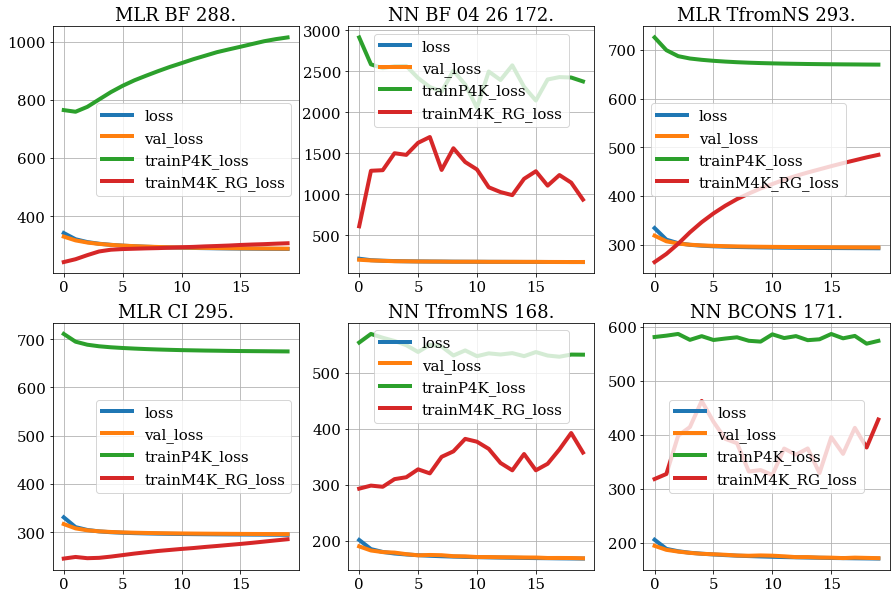

In [16]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

for iax in range(6):
    
    iax_ar = iax//3
    subp = ax[iax_ar][iax-3*iax_ar]
    
    if iax==0: h = hist_MLR_BF; tit = 'MLR BF'
    elif iax==1: h = hist_NN_BF1; tit = 'NN BF 04 26'
    elif iax==2: h = hist_MLR_TfromNS; tit = 'MLR TfromNS'
    elif iax==3: h = hist_MLR_CI; tit = 'MLR CI'
    elif iax==4: h = hist_NN_TfromNS; tit = 'NN TfromNS'
    elif iax==5: h = hist_NN_BCONS0; tit = 'NN BCONS'
    
    for key in h.keys():
        subp.plot(h[key],label=key)
    subp.legend()
    subp.set_title(tit+' '+str(h['val_loss'][-1])[:4])
    subp.grid()

In [17]:
path_LOGI_TfromNS = path_PKL + 'PKL_DATA2021_04_26_LOGI_PERC_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_LOGI_TfromNS,'rb')
hist_LOGI_TfromNS = pickle.load(hf)
hist_LOGI_TfromNS = hist_LOGI_TfromNS['hist']

In [18]:
path_LOGI_BCONS = path_PKL + 'PKL_DATA2021_04_26_LOGI_PERC_RH_BCONS_LHF_nsDELQ_hist.pkl'
hf = open(path_LOGI_BCONS,'rb')
hist_LOGI_BCONS = pickle.load(hf)
hist_LOGI_BCONS = hist_LOGI_BCONS['hist']

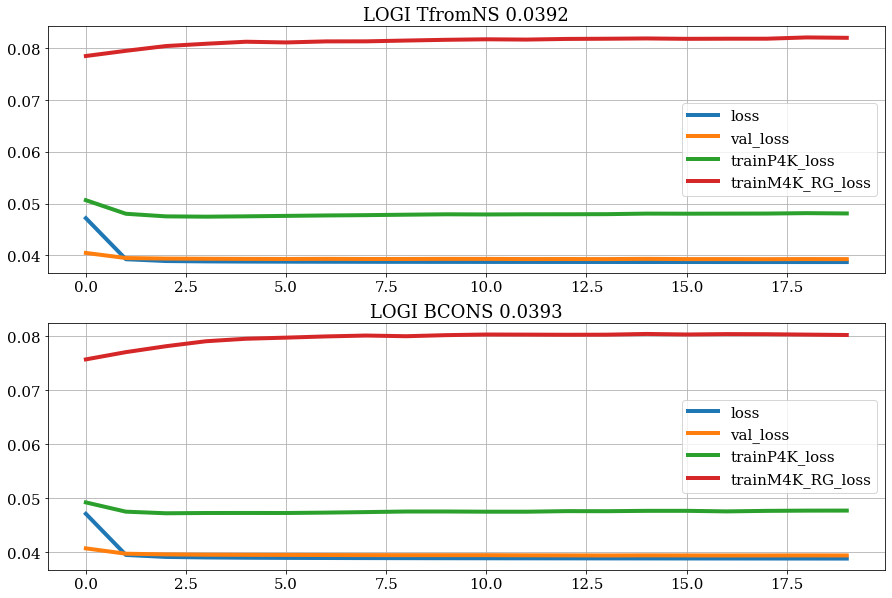

In [19]:
fig,ax = plt.subplots(2,1,figsize=(15,10))

for iax in range(2):
    
    iax_ar = iax//1
    subp = ax[iax]
    
    if iax==0: h = hist_LOGI_TfromNS; tit = 'LOGI TfromNS'
    elif iax==1: h = hist_LOGI_BCONS; tit = 'LOGI BCONS'
    
    for key in h.keys():
        subp.plot(h[key],label=key)
    subp.legend()
    subp.set_title(tit+' '+str(h['val_loss'][-1])[:6])
    subp.grid()

## Figure

In [22]:
fz = 40
lw = 6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [23]:
epoch = np.arange(1,21)

(0, 20)

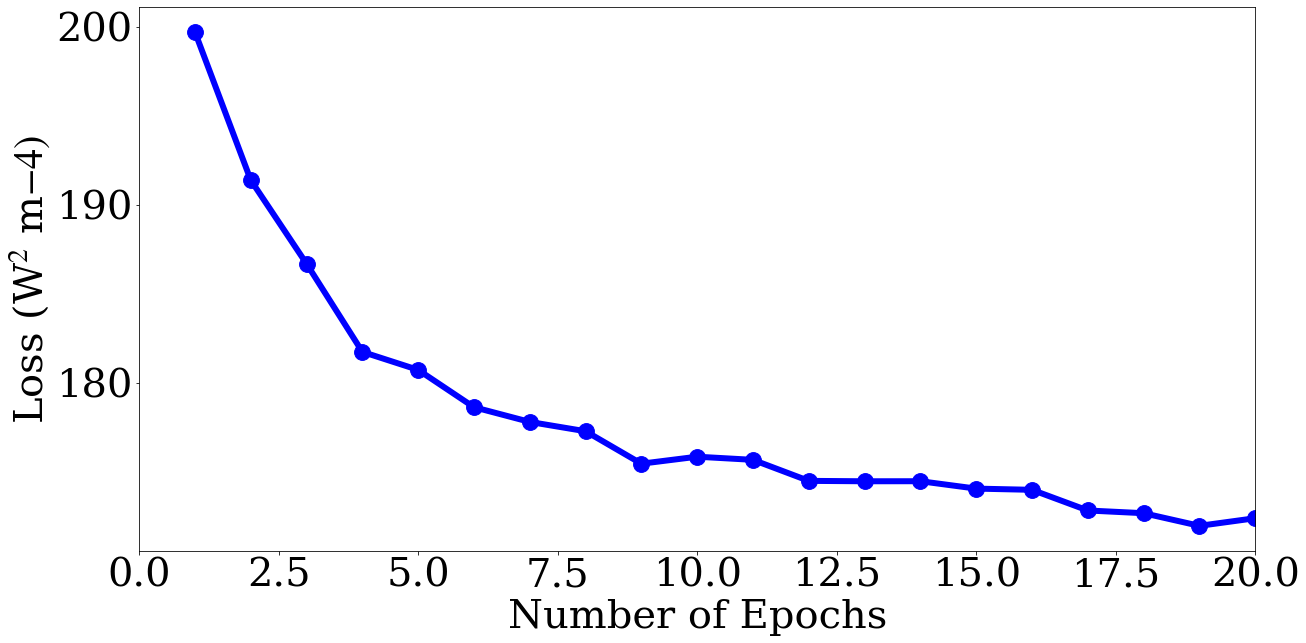

In [229]:
plt.figure(figsize=(20,10))

plt.scatter(epoch,hist_NN_BF1['val_loss'],s=siz,color='b')
plt.plot(epoch,hist_NN_BF1['val_loss'],color='b')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (W$^{2}$ m${-4})$')
plt.xlim((0,20))

(0, 20)

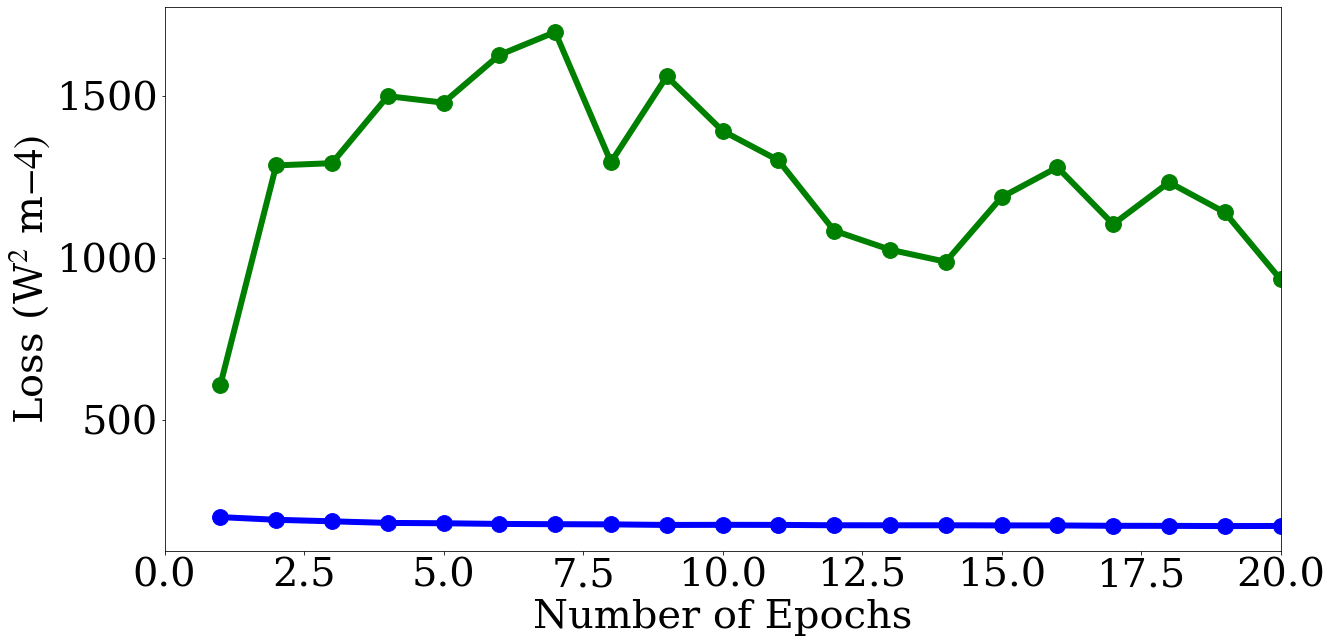

In [230]:
plt.figure(figsize=(20,10))

plt.scatter(epoch,hist_NN_BF1['val_loss'],s=siz,color='b')
plt.plot(epoch,hist_NN_BF1['val_loss'],color='b')
plt.scatter(epoch,hist_NN_BF1['trainM4K_RG_loss'],s=siz,color='g')
plt.plot(epoch,hist_NN_BF1['trainM4K_RG_loss'],color='g')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (W$^{2}$ m${-4})$')
plt.xlim((0,20))

(0, 20)

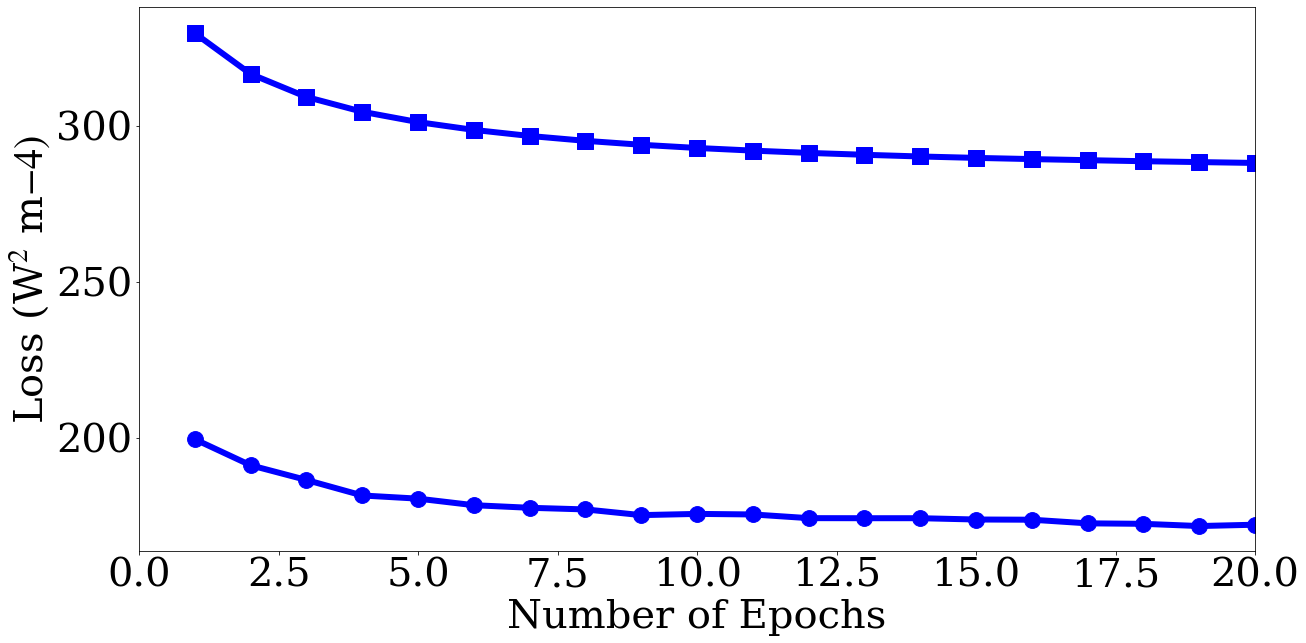

In [232]:
plt.figure(figsize=(20,10))

plt.scatter(epoch,hist_NN_BF1['val_loss'],s=siz,color='b')
plt.plot(epoch,hist_NN_BF1['val_loss'],color='b')

plt.scatter(epoch,hist_MLR_BF['val_loss'],s=siz,color='b',marker='s')
plt.plot(epoch,hist_MLR_BF['val_loss'],color='b')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss (W$^{2}$ m${-4})$')
plt.xlim((0,20))

(0, 20)

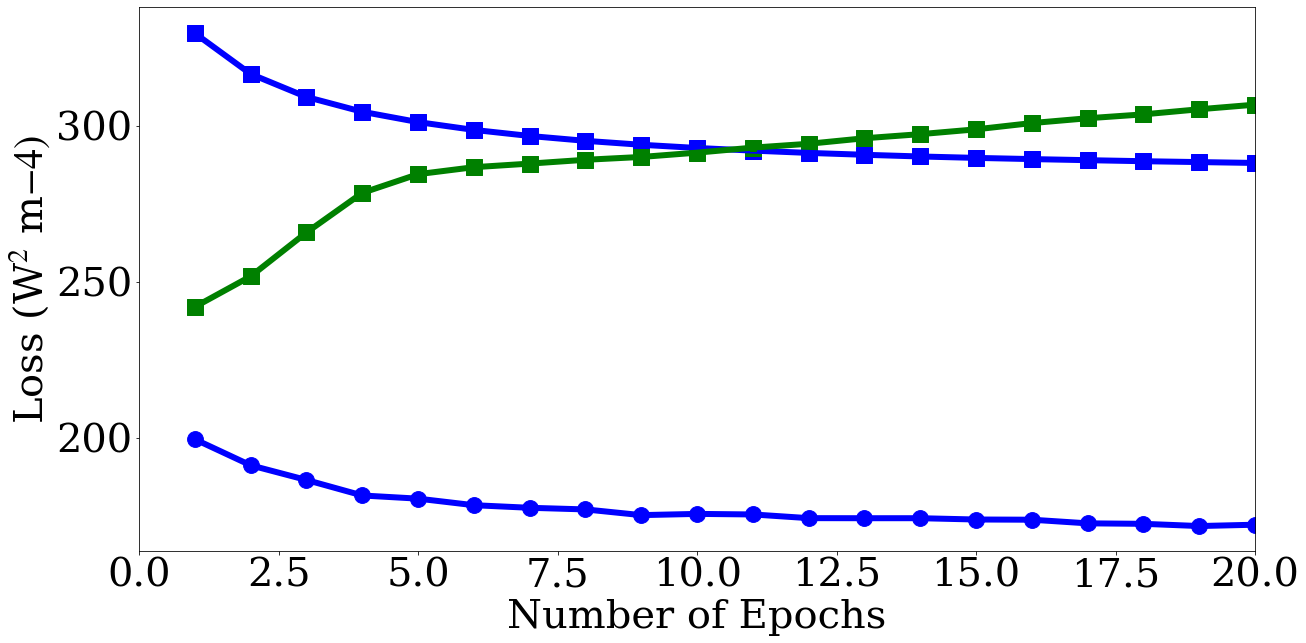

In [234]:
plt.figure(figsize=(20,10))

plt.scatter(epoch,hist_NN_BF1['val_loss'],s=siz,color='b')
plt.plot(epoch,hist_NN_BF1['val_loss'],color='b')

plt.scatter(epoch,hist_MLR_BF['val_loss'],s=siz,color='b',marker='s')
plt.plot(epoch,hist_MLR_BF['val_loss'],color='b')

plt.scatter(epoch,hist_MLR_BF['trainM4K_RG_loss'],s=siz,color='g',marker='s')
plt.plot(epoch,hist_MLR_BF['trainM4K_RG_loss'],color='g',marker='s')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss (W$^{2}$ m${-4})$')
plt.xlim((0,20))

(0, 20)

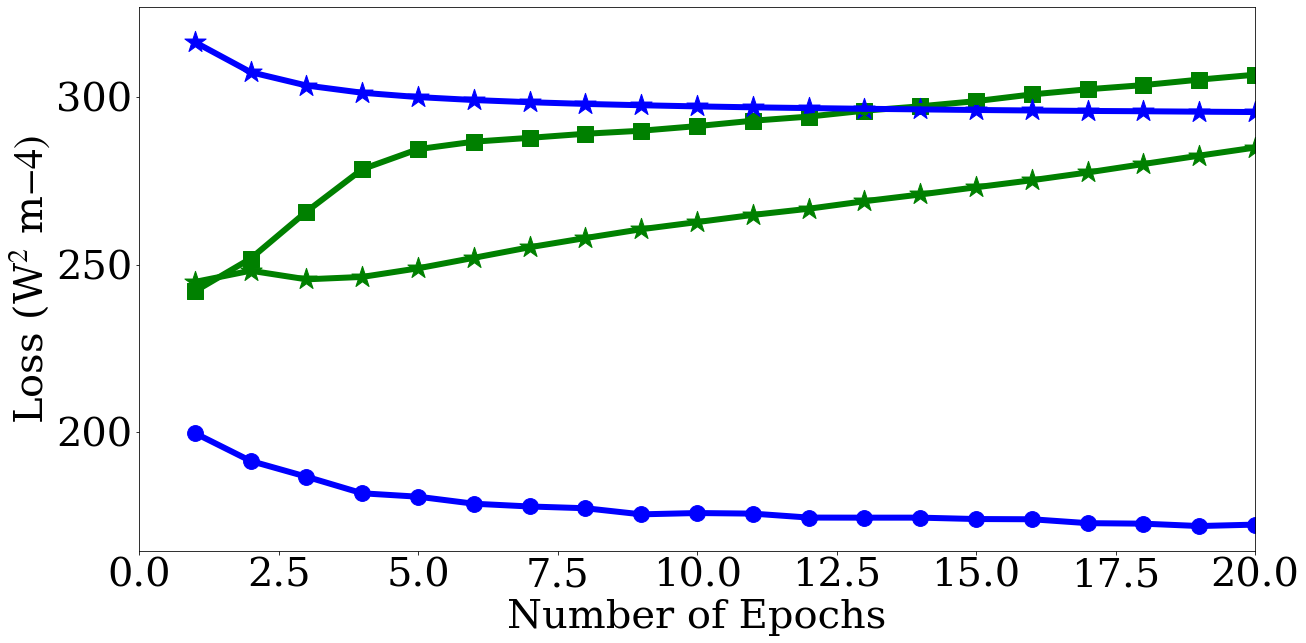

In [24]:
plt.figure(figsize=(20,10))

plt.scatter(epoch,hist_NN_BF1['val_loss'],s=siz,color='b')
plt.plot(epoch,hist_NN_BF1['val_loss'],color='b')

# plt.scatter(epoch,hist_MLR_BF['val_loss'],s=siz,color='b',marker='s')
# plt.plot(epoch,hist_MLR_BF['val_loss'],color='b')

plt.scatter(epoch,hist_MLR_BF['trainM4K_RG_loss'],s=siz,color='g',marker='s')
plt.plot(epoch,hist_MLR_BF['trainM4K_RG_loss'],color='g',marker='s')

plt.scatter(epoch,hist_MLR_CI['val_loss'],color='b',marker='*',s=2*siz)
plt.plot(epoch,hist_MLR_CI['val_loss'],color='b',marker='*')

plt.scatter(epoch,hist_MLR_CI['trainM4K_RG_loss'],color='g',marker='*',s=2*siz)
plt.plot(epoch,hist_MLR_CI['trainM4K_RG_loss'],color='g',marker='*')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss (W$^{2}$ m${-4})$')
plt.xlim((0,20))

(0, 20)

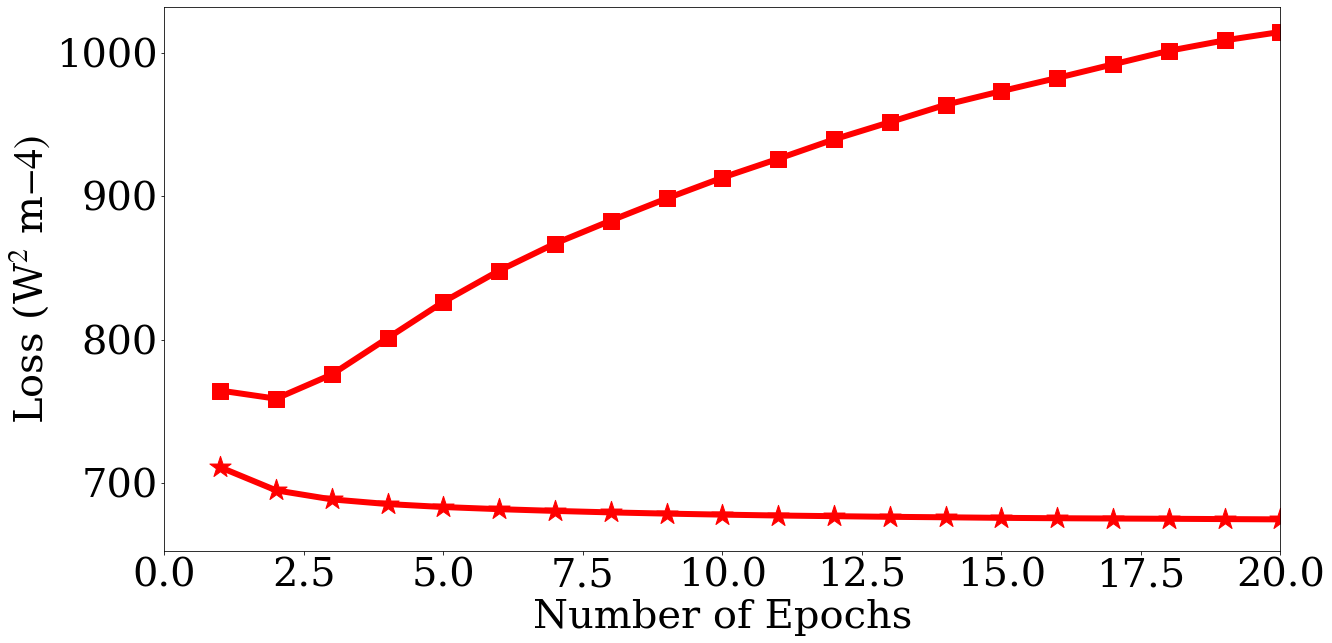

In [26]:
plt.figure(figsize=(20,10))

# plt.scatter(epoch,hist_NN_BF1['trainP4K_loss'],s=siz,color='r')
# plt.plot(epoch,hist_NN_BF1['trainP4K_loss'],color='r')

# plt.scatter(epoch,hist_MLR_BF['val_loss'],s=siz,color='b',marker='s')
# plt.plot(epoch,hist_MLR_BF['val_loss'],color='b')

plt.scatter(epoch,hist_MLR_BF['trainP4K_loss'],s=siz,color='r',marker='s')
plt.plot(epoch,hist_MLR_BF['trainP4K_loss'],color='r',marker='s')

plt.scatter(epoch,hist_MLR_CI['trainP4K_loss'],color='r',marker='*',s=2*siz)
plt.plot(epoch,hist_MLR_CI['trainP4K_loss'],color='r',marker='*')

# plt.scatter(epoch,hist_MLR_CI['trainM4K_RG_loss'],color='g',marker='*',s=2*siz)
# plt.plot(epoch,hist_MLR_CI['trainM4K_RG_loss'],color='g',marker='*')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss (W$^{2}$ m${-4})$')
plt.xlim((0,20))